In [37]:
import tensorflow as tf
from modules.metropolis import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from collections import Counter

@dataclass
class TestProblem(QFTProblem):
    size: tuple[float, float] = (10, 100)

    def volume(self) -> npt.NDArray:
        return np.array(self.size)

    def get_amplitude(self, x_n: tf.Tensor, ns: npt.NDArray, training: bool = False) -> tf.Tensor:
        mask = tf.sequence_mask(ns, maxlen = x_n.shape[-2])

        mask = tf.cast(mask, x_n.dtype)
        masked_sin = tf.where(mask > 0, tf.sin(x_n[:, :, 0]) * tf.sin(x_n[:, :, 1] / 20), tf.ones_like(x_n[:, :, 0])) # type: ignore
        profile = tf.pow(tf.reduce_prod(masked_sin, axis=1), 2)

        ns = tf.cast(ns, x_n.dtype) # type: ignore

        return profile * np.exp(-ns / 10.) / np.power(np.prod(self.volume()), ns / 2.) * (0.1 + ns)

In [2]:
test_problem = TestProblem()

metropolis = FockSpaceMetropolis(test_problem, 5, rng=np.random.default_rng(0))

x_n, ampilitude = metropolis.new_configuration(2, 2)
print("initial\n", x_n)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)
            
x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_step, _ = metropolis.step(x_n, ampilitude)
print("step one\n", x_step)
x_n, _ = metropolis.new_configuration(2, 0)
print("initial\n", x_n)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)


initial
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 7.29655446, 17.56556206],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([2, 2], dtype=int32))
add new
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 0.28319671, 12.42832765],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 6.70624415, 64.71895116],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([3, 3], dtype=int32))
remove one
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],

In [4]:
import modules.metropolis as metro
import importlib
importlib.reload(metro)

batch = 32
n_max = 10

test_problem = TestProblem()
test_metropolis = metro.FockSpaceMetropolis(test_problem, n_max, rng=np.random.default_rng(0))

def metropolis_step(metropolis: FockSpaceMetropolis, batch = 32, n_init = 5):
    x_recent, amplitude_recent = metropolis.new_configuration(batch, n_init)
    while True:
        x_recent, amplitude_recent = metropolis.step(x_recent, amplitude_recent)
        yield x_recent.x_n, x_recent.n_s

dataset = tf.data.Dataset.from_generator(
    lambda: metropolis_step(test_metropolis, batch = batch),
    output_signature = (
        tf.TensorSpec(shape=(batch, n_max, 2), dtype=tf.float32, name="features"), # type: ignore
        tf.TensorSpec(shape=(batch), dtype=tf.int32) # type: ignore
    )
)


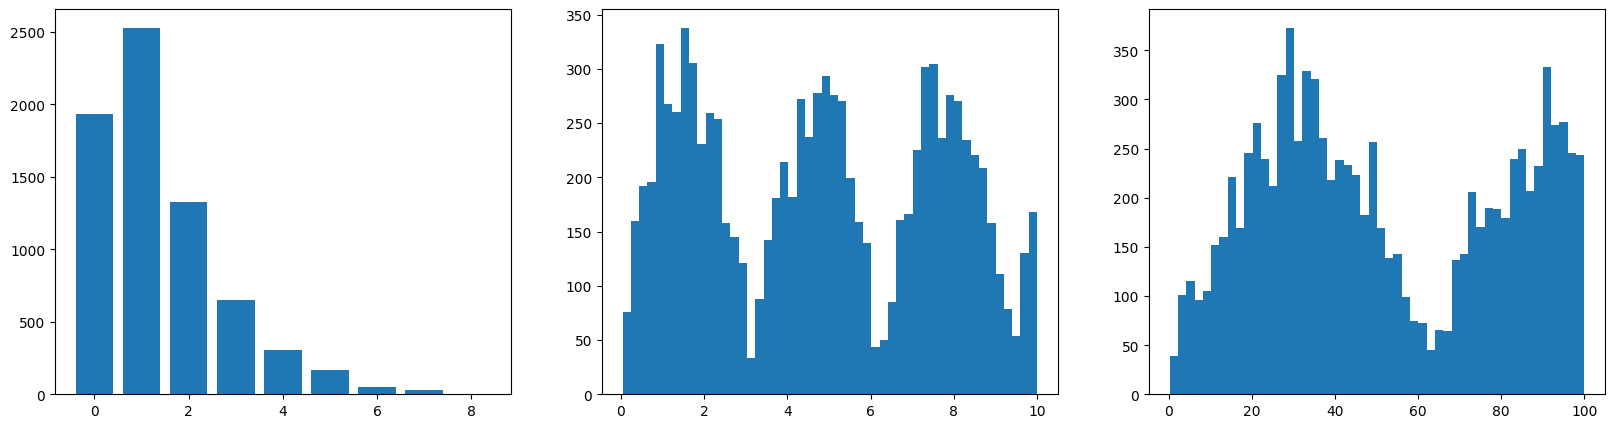

In [3]:
from collections import Counter

configurations = dataset.unbatch().skip(3000).take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

In [5]:
tfds.benchmark(dataset.take(10000), batch_size = batch)


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 15893.58 ex/sec (total: 320032 ex, 20.14 sec)
Examples/sec (First only) 77.03 ex/sec (total: 32 ex, 0.42 sec)
Examples/sec (First excluded) 16226.76 ex/sec (total: 320000 ex, 19.72 sec)


,duration,num_examples,avg
first+lasts,20.135933,320032,15893.576999
first,0.415424,32,77.029771
lasts,19.720509,320000,16226.761610


In [6]:
with tf.GradientTape() as g2:
    with tf.GradientTape() as g:
        x_n, n_s = next(iter(configurations.batch(1).skip(40))) # type: ignore

        x_n = tf.Variable(x_n)
        print(x_n, n_s)

        value = test_problem.get_amplitude(x_n, n_s) # type: ignore

    gradient = g.gradient(value, x_n)

hessian = g2.jacobian(gradient, x_n)
# laplacian = tf.linalg.trace(laplacian)
laplacian = tf.einsum('bpibpi->bpi', hessian)

print("y", value)
print("gradient", gradient)
print("laplacian", laplacian)

<tf.Variable 'Variable:0' shape=(1, 10, 2) dtype=float32, numpy=
array([[[ 5.0902042 , 72.595436  ],
        [ 8.687788  , 43.252575  ],
        [ 0.95789915,  8.690153  ],
        [ 0.83288276, 89.49227   ],
        [ 8.087362  , 43.382     ],
        [ 1.1243632 , 23.481735  ],
        [ 9.022893  , 62.04052   ],
        [ 5.9924383 , 55.55923   ],
        [ 8.205903  , 53.68986   ],
        [ 6.432432  , 77.57588   ]]], dtype=float32)> tf.Tensor([2], shape=(1,), dtype=int32)
y tf.Tensor([0.00010165], shape=(1,), dtype=float32)
gradient tf.Tensor(
[[[-8.0685510e-05  1.9141149e-05]
  [-2.2399958e-04 -6.8329973e-06]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]], shape=(1, 10, 2), dtype=float32)
laplacian tf.Tensor(
[[[-1.7127609e-04  1.2939470e-06]
  [ 4.3509703

In [7]:
x0 = 4.85924769
x1 = 23.90258908

print("y", np.power(np.sin(x0) * np.sin(x1 / 20), 2) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx0", np.sin(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx1", 1 / 20 * np.sin(x0) ** 2 * np.sin(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx0^2", 2 * np.cos(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx1^2", 1 / 200 * np.sin(x0) ** 2 * np.cos(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)

y 0.026654735548713143
dy/dx0 -0.007885733618981039
dy/dx1 0.0010512547138865212
d^2y/dx0^2 -0.05214298429068455
d^2y/dx1^2 -0.00011254309365187722


In [20]:
from importlib import reload
import modules.hamiltonians.hamiltonian_terms as terms
reload(terms)

kinetic_term = terms.KineticTerm(0.5)

x_n, n_s = next(iter(configurations.batch(4).skip(20))) # type: ignore
x_n: tf.Tensor = tf.Variable(x_n) # type: ignore

print("kinetic term")
print(kinetic_term.local_energy(x_n, n_s, test_problem))

chemical_potential = terms.ExternalPotential.chemical_potential(1)

print("Chemical potential")
print(chemical_potential.local_energy(x_n, n_s, test_problem))

kinetic term


NameError: name 'test_problem' is not defined

# Model learning

In [16]:
import keras
import modules.ansatz_nn as ansatz_nn
from modules.hamiltonians.hamiltonian_terms import *
import modules.hamiltonians.lieb_liniger_model as ll_model
import importlib
import modules.metropolis as metro
import matplotlib.pyplot as plt
from collections import Counter
importlib.reload(ansatz_nn)
importlib.reload(ll_model)
importlib.reload(metro)

input_dim = 2

ds1 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim, name = "deep_set_1")
ds2 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim, name = "deep_set_2")

hamiltonian = HamiltonianSum([KineticTerm(0.5), ExternalPotential.chemical_potential(100)])

test_model = ansatz_nn.QFTNeuralNet(
    np.array([10, 100]), 
    ds1, 
    ds2,
    hamiltonian,
    is_periodic = False
)

dataset = metro.make_dataset(test_model, 32, 10, 5)

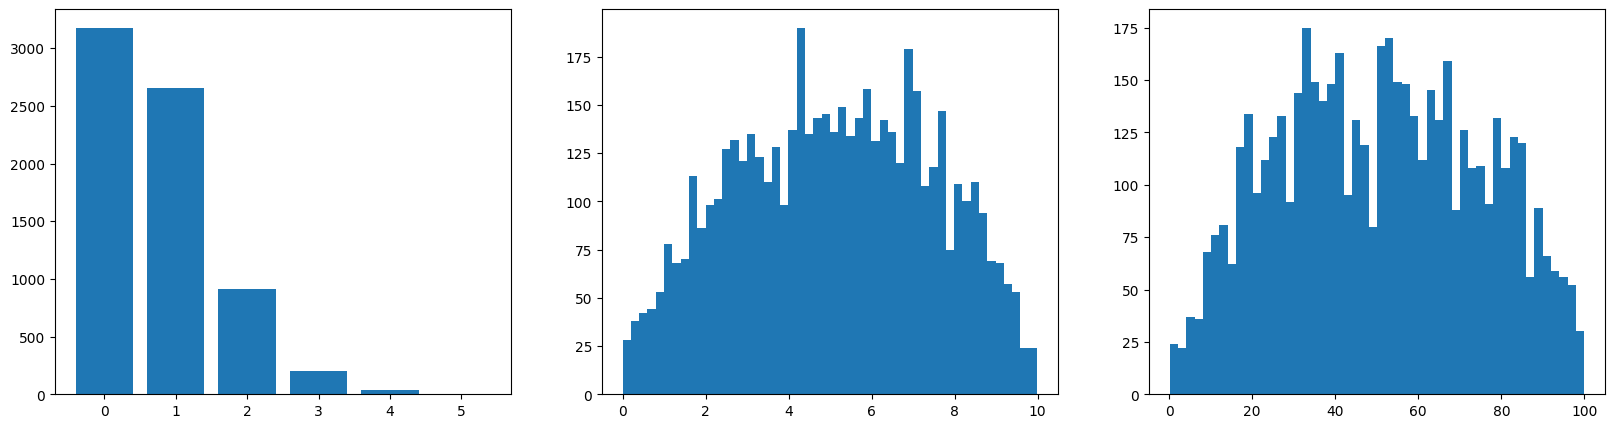

In [10]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-2,
    decay_steps = 20,
    decay_rate = 0.95,
    staircase=True
)

test_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_schedule),
    regularization_lr_modifier = 100
)

history = test_model.fit(
    dataset.skip(500).take(1000),
    epochs = 100,
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - energy: -70.0441 - loss: -70.0441 - mean_particle_number: 0.7997
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - energy: -80.8135 - loss: -80.8135 - mean_particle_number: 0.8495
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - energy: -44.1695 - loss: -44.1695 - mean_particle_number: 0.9547
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - energy: -79.1796 - loss: -79.1796 - mean_particle_number: 0.9814
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - energy: -102.3403 - loss: -102.3403 - mean_particle_number: 1.0572
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - energy: -113.8451 - loss: -113.8451 - mean_particle_number: 1.1723
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - energy: -106.3340 - loss: -106.3340 - mean_particle_number: 1.2024
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - energy: -117.3868 - loss: -117.3868 - mean_particle_number: 1.2344


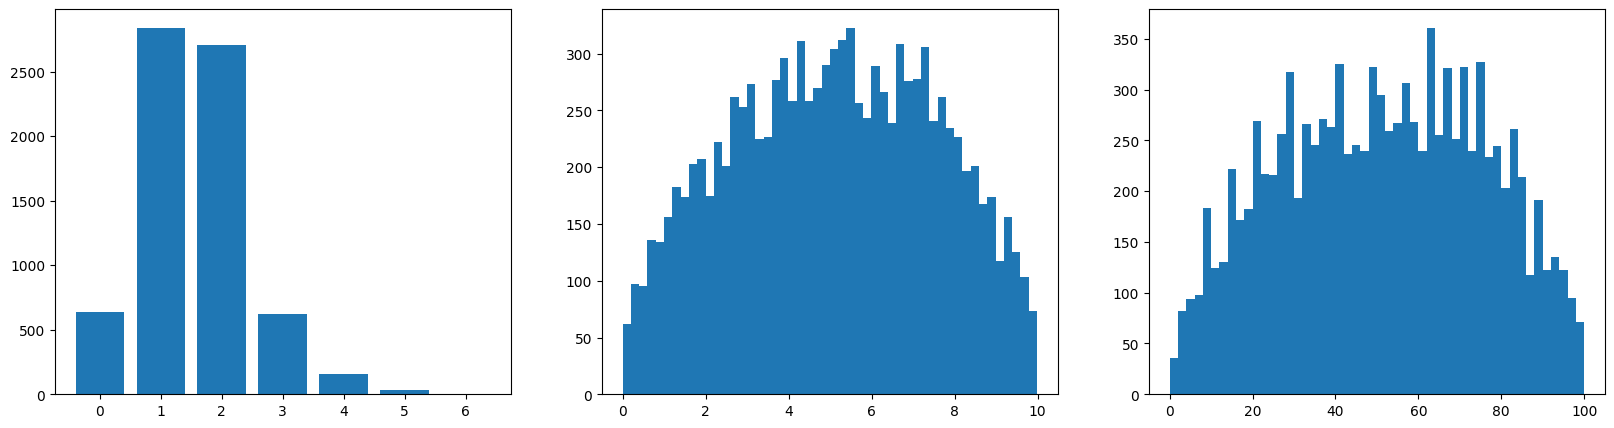

In [12]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

(-1000.0, 1000.0)

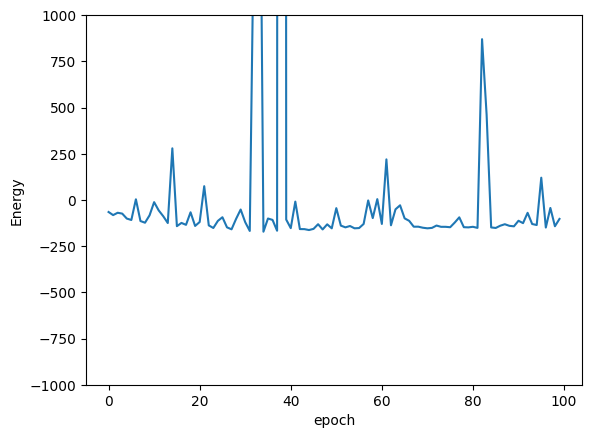

In [15]:
fig, ax = plt.subplots()

ax.plot(test_model.history.history["loss"])
ax.set_xlabel("epoch")
ax.set_ylabel("Energy")
ax.set_ylim(-1000, 1000)

# Lieb Lieniger model

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import modules.ansatz_nn as ansatz_nn
import modules.hamiltonians.hamiltonian_terms as h_terms
import modules.hamiltonians.lieb_liniger_model as ll_model
import importlib
import modules.metropolis as metro
import matplotlib.pyplot as plt
from collections import Counter
importlib.reload(ansatz_nn)
importlib.reload(ll_model)
importlib.reload(metro)
importlib.reload(h_terms)

def embedding_1d(x, l):
    tf.concat(x, l - x, -1)


input_dim = 1
L = 1

ds1 = ansatz_nn.DeepSets(64, 2, 2, input_dim=input_dim, name = "deep_set_1")
ds2 = ansatz_nn.DeepSets(64, 2, 2, input_dim=input_dim, name = "deep_set_2")

hamiltonian = ll_model.LiebLinigerHamiltonian(0.5, (8.75 * np.pi) ** 2, 1e6)
test_model = ansatz_nn.QFTNeuralNet(
    np.array([L]), 
    ds1, 
    ds2,
    hamiltonian,
    is_periodic = False,
)
dataset = metro.make_dataset(test_model, 64, 10, 5)

# hamiltonian = ll_model.LiebLinigerHamiltonian(0.5, 185, 10)
# test_model = ansatz_nn.QFTNeuralNet(
#     np.array([1]), 
#     ds1, 
#     ds2,
#     hamiltonian,
#     is_periodic = False,
# )
# dataset = metro.make_dataset(test_model, 64, 10, 5)

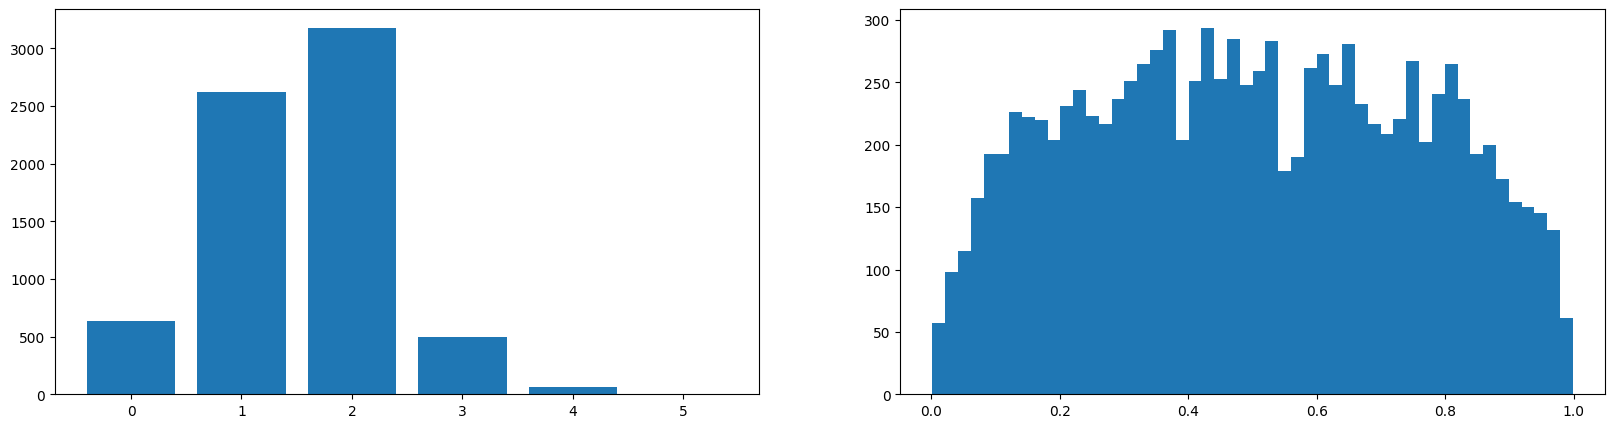

In [24]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()

axes[1].hist(positions_1, bins=50);

In [25]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-1,
    decay_steps = 10,
    decay_rate = 0.95,
    staircase=True
)

test_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_schedule),
    regularization_lr_modifier = 1,
)

history = test_model.fit(
    dataset.skip(500).take(1000),
    epochs = 500,
)

Epoch 1/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - energy: 4574.4199 - loss: 4574.4199 - mean_particle_number: 1.6098
Epoch 2/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: 1799.7971 - loss: 1799.7971 - mean_particle_number: 0.1976
Epoch 3/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: -2414.6951 - loss: -2414.6951 - mean_particle_number: 3.1956
Epoch 4/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: -2785.1221 - loss: -2785.1221 - mean_particle_number: 3.6858
Epoch 5/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: -2816.7598 - loss: -2816.7598 - mean_particle_number: 3.7276
Epoch 6/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: -2608.9551 - loss: -2608.9551 - mean_particle_number: 3.4526
Epoch 7/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: -2480.4478 - loss: -2480.4478 - mean_particle_number: 3.2826
Epoch 8/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - energy: -3894.7776 - loss: -3894.7776 - mean_part

KeyboardInterrupt: 

Text(0, 0.5, 'Mean particles')

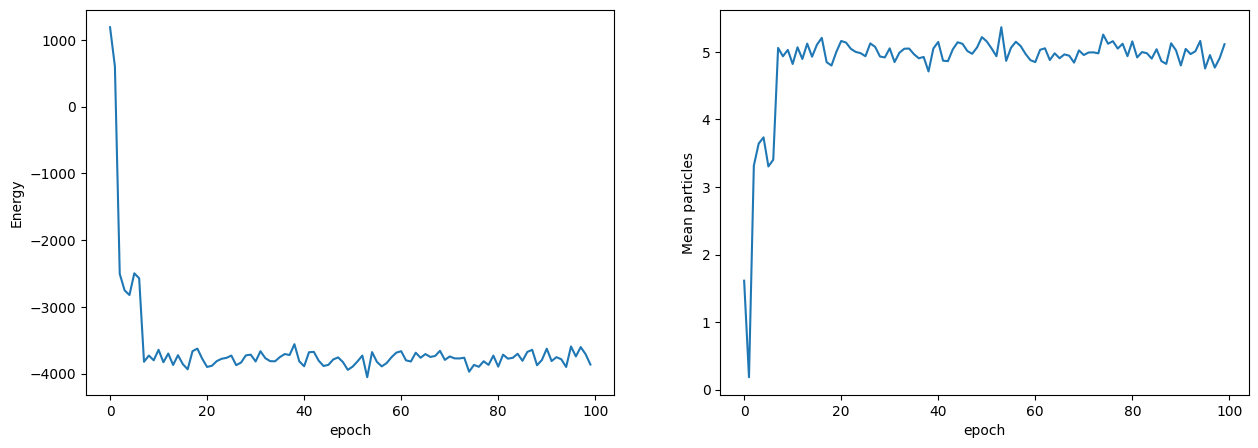

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(test_model.history.history["energy"])
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Energy")

axes[1].plot(test_model.history.history["mean_particle_number"])
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Mean particles")

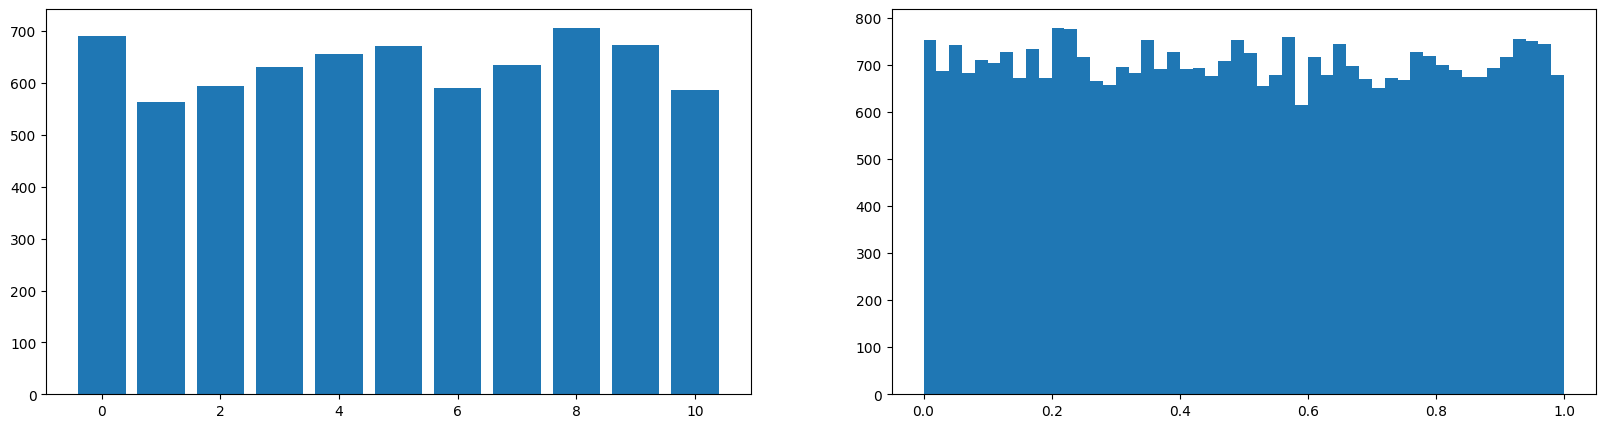

In [27]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()

axes[1].hist(positions_1, bins=50);